In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii 
from astropy import units as u

In [2]:
tab = astropy.io.ascii.read("/Users/huihaoz/Downloads/PS_2023.02.22_19.19.00.csv")

In [3]:
print(tab.colnames)

['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg', 'st

## calculate contrast and separation

Change: use the new datafile, and from gaia_dist to sy_dist

the number in cal_rad?

In [4]:
sma_arr[ind]

NameError: name 'sma_arr' is not defined

In [5]:
rad_arr[ind]

NameError: name 'rad_arr' is not defined

In [6]:
np.mean(tab['st_teff'])

5433.8019215270415

In [7]:
contrast_arr = np.zeros((len(tab)))
sma_arr = np.zeros((len(tab)))
sep_arr = np.zeros((len(tab)))
rad_arr = np.zeros((len(tab)))
dis_arr = np.zeros((len(tab)))

def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.jupiterRad)
    elif mass < (0.41 * u.jupiterMass):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.jupiterRad)
    elif mass < (0.08 * u.solMass):
        rad = ((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)
    else:
        rad = ((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad) 
    return(rad)

k = 0
for i, tmp in enumerate(tab["pl_name"]):
    if tab["pl_orbper"].mask[i] == False:
        # calculating sma
        if tab["pl_orbsmax"].mask[i] == True:
            if tab["st_mass"].mask[i] == True:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * 1.0)**(0.33) * u.AU
            else:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * tab["st_mass"][i])**(0.33) * u.AU
        else:
            sma = tab["pl_orbsmax"][i] * u.AU

        # calculating angular separation
        if tab["sy_dist"].mask[i] == True:
            if tab["sy_dist"].mask[i] == True:
                dis = 999 * u.parsec
            else:
                dis = tab["sy_dist"][i] * u.parsec
        else:
            dis = tab["sy_dist"][i] * u.parsec
        sep = ((sma / dis).decompose() * u.radian).to(u.arcsec)

        # calculating planet radius, https://arxiv.org/pdf/1603.08614.pdf
        if tab["pl_radj"].mask[i] == True:
            if tab["pl_bmassj"].mask[i] == False:
                mass = tab["pl_bmassj"][i] * u.jupiterMass
                rad = cal_rad(mass)
            else:
                rad = 1.0 * u.jupiterRad
        else:
            rad = tab["pl_radj"][i] * u.jupiterRad

        # calculating contrast
        albedo = 0.3
        con = ((rad / sma).decompose())**2 * albedo


        if (con > 1e-7) & (sep.value > 5e-3) & (tab["dec"][i] > -100.0) & (rad < (0.2 * u.jupiterRad)):
#             print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i], \
#                   tab["st_k"][i], tab["st_wise1"][i])
            k = k + 1
#         elif tab["pl_name"][i] == "Ross 128 b":
#              print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i])           
        else:
            1 == 1

        sma_arr[i] = sma.value
        sep_arr[i] = sep.value
        rad_arr[i] = rad.value
        contrast_arr[i] = con
        dis_arr[i] = dis.value
    else:
        sma_arr[i] = 1.0
        sep_arr[i] = 1e-5
        rad_arr[i] = 1.0
        contrast_arr[i] = 1e-10       
        dis_arr[i] = 1e3

## Plot seleted targets

Only changed lambda_D,

1$\mu$m to 2$\mu$m, 30 m to 39.3 m

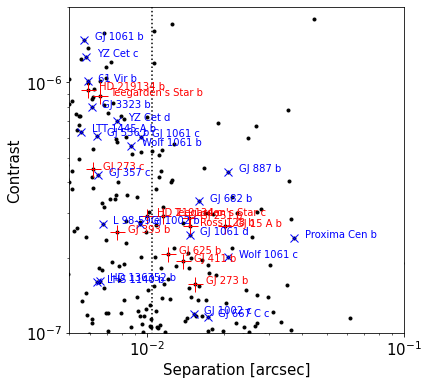

In [8]:
con_threshold = 1e-7
sep_threshold = 5e-3
rad_threshold = 0.2

plt.figure(figsize=(6,6))

font_size = 15

plt.plot(sep_arr, contrast_arr, 'k.')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Separation [arcsec]", fontsize=font_size)
plt.ylabel("Contrast", fontsize=font_size)
plt.gca().tick_params(labelsize=font_size)
plt.xlim(5e-3, 1e-1)
plt.ylim(1e-7, 2e-6)


lambda_D = (((2.0 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
plt.vlines(lambda_D.value, 1e-10, 1e-5, color="black", linestyle="dotted")

# lambda_D = (((2.0 * u.micron) / (22.4 * u.meter).decompose()) * u.radian).to(u.arcsec)
# plt.vlines(lambda_D.value, 1e-10, 1e-5, color="blue", linestyle="dashed")

# plt.hlines(5e-7, 1e-3, 1e-1, color="k", linestyle="solid")

ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        plt.plot(sep_arr[i], contrast_arr[i], color="r", ms=15, marker="+")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="red")
    else:
        plt.plot(sep_arr[i], contrast_arr[i], color="b", ms=8, marker="x")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="blue")




In [9]:
temp = [183.707, 224.199, 365.493, 319.321, 266.145, 355.467, 306.961, 240.079, 258.630, 427.655, 217.185, 282.712, 201.836, 275.106]

In [10]:
rad_arr[ind]**2 * 100000

array([3716.98865454,  831.23508608,  945.59285816,  949.29882663,
       1084.84720779, 1049.97632267, 2016.783496  , 2801.30255565,
       1907.37039786,  872.86094533, 1251.43717645, 2312.07817206,
       1074.81507024, 1752.37352961, 3953.86274338, 1853.01752781,
       2647.05842061, 3132.34970684, 2964.79712436, 2190.4       ,
       2044.9       , 1822.5       , 2041.77872752, 2131.6       ,
       1345.6       ,  827.11979992,  960.34918381,  817.45429331,
        843.48606451, 1143.57690784, 2319.72940614,  856.93634727,
        835.33442596])

In [11]:
(((rad_arr[ind]- np.mean(rad_arr[ind]))/ np.std(rad_arr[ind]))) * 100 + 140

array([343.07407464,  25.42493906,  44.3967844 ,  44.99183115,
        66.00957456,  60.73438801, 184.34324356, 263.60458283,
       172.13424982,  32.47332917,  90.11439479, 215.73120969,
        64.50073492, 154.2225679 , 361.97960704, 165.93899955,
       248.99759725, 293.65422747, 278.6549561 , 203.05562845,
       187.42680238, 162.42068068, 187.08554047, 196.80409802,
       103.03114162,  24.71861664,  46.75926361,  23.05274655,
        27.51733459,  74.70594297, 216.51698384,  29.79713988,
        26.1267884 ])

In [12]:
lambda_D.to(u.mas)

<Quantity 10.4969367 mas>

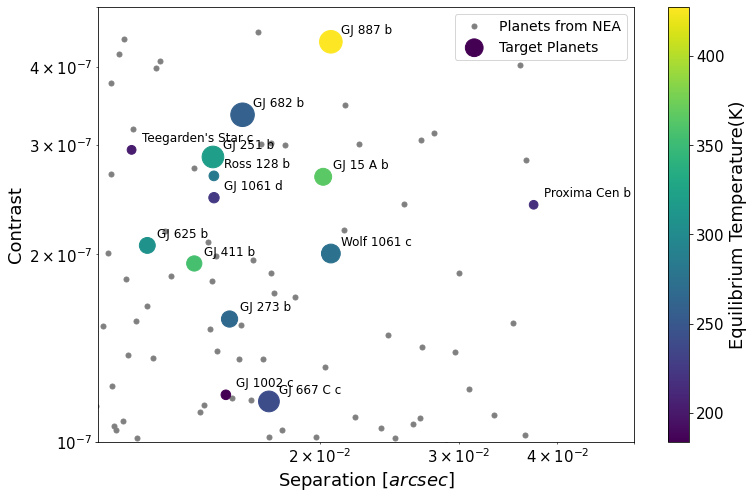

In [57]:
lambda_D = (((2.0 * u.micron) / (39.3 * u.meter).decompose()) * u.radian).to(u.arcsec)
con_threshold = 1e-7
sep_threshold = lambda_D.value
rad_threshold = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

font_size = 18

ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.03, contrast_arr[i] * 1.03), rotation=rot_arr[ii], color="black",size=12)
    else:
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.03, contrast_arr[i] * 1.03), rotation=rot_arr[ii], color="black",size=12)

plt.plot(sep_arr, contrast_arr, 'o',color="grey",ms=5,label="Planets from NEA",zorder=-1)

sc =plt.scatter(sep_arr[ind], contrast_arr[ind],s=rad_arr[ind]**3 * 100000,c=temp,label="Target Planets",zorder=1)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Equilibrium Temperature(K)',size=18)
fig.patch.set_facecolor('white')
plt.legend( prop={'size': 14})
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'Separation [$arcsec$]', fontsize=font_size)
plt.ylabel(r'Contrast', fontsize=font_size)
plt.xlim(lambda_D.value, 5e-2)
plt.ylim(1e-7, 0.5e-6)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)


In [ ]:
rot_arr

In [ ]:
def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.R_earth)
    elif mass < ((0.41 * u.jupiterMass).to(u.earthMass)):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.R_earth)
    elif mass < ((0.08 * u.solMass).to(u.earthMass)):
        rad = (((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)).to(u.R_earth)
    else:
        rad = (((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad)).to(u.R_earth)
    return(rad)


set i = 90

In [ ]:
ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold) & (rad_arr < 0.2))
rot_arr = np.zeros((len(contrast_arr[ind]), ))
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        print(tab["pl_name"][i],tab["pl_bmasse"][i],cal_rad(tab["pl_bmasse"][i]*u.earthMass),tab["pl_orbsmax"][i],tab["sy_dist"][i],tab["st_rad"][i],tab["st_logg"][i],tab["st_teff"][i])
    else:
        print(tab["pl_name"][i],tab["pl_bmasse"][i],cal_rad(tab["pl_bmasse"][i]*u.earthMass), tab["pl_orbsmax"][i],tab["sy_dist"][i],tab["st_rad"][i],tab["st_logg"][i],tab["st_teff"][i])

In [ ]:
cal_rad(1)

In [ ]:
tab["pl_bmasse"]*u.earthMass

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/Users/huihaoz/Documents/reseatch/PT_PES.txt', sep=",")

In [ ]:
data